In [1]:
import numpy as np
import matplotlib.pylab as plt
from pylab import *
import sys
from fft_utils import fft_1d, shift_1d


In [2]:
e0 = np.loadtxt('837nm.dat')        #load the reference pulse, pump @836 nm
e0 = e0.T
e1 = np.sqrt(e0[1])
e1_ph = e0[2]
e = np.array(e1)*np.exp(-1j*(np.array(e1_ph)))#reforming E-field

original_trace = np.loadtxt('traces/trace8.frg')		#load FROG trace from experiment
N = len(e0[0])		#timesteps
N_max = np.max(e0[0])
N_min = np.min(e0[0])

t = e0[0]-N_min
T0 = N_max-N_min	#total time duration
dt = T0/(N-1)
df = 1.0/T0		#frequency steps
TD = N			#time delay for FROG-trace generation
freq = np.arange(0,1/dt+df,df)*1000
print(e.shape)

(128,)


In [3]:
A = 3.0			#Amplitude of Raman pulse
a = 1.0			#intensity dependent factor ##it is not used in this program, ignore it.
a2 = 2.50*10**-6	#second order phase factor
a3 = 3.0*10**-9		#third order phase factor

f0 = 1.600/1000.0	#Raman center-wavelength
f1 = 0.25/1000.0	#Red-shifted center-wavelength

i0 = 333.0		#unit: fs
tau1 = T0/2+i0-400	#Raman pulse peak time
tau2 = tau1-700		#Red-shifted pulse peak time

In [4]:
def gaussian_pulse(T,f,A,phase,tau):
    w0 = f*2*np.pi		#central angular frequency of pulse
    temp = -1j*w0*(t-tau) + 1j*phase
    E = A*np.sqrt(np.exp(-4.0*np.log(2.0)/np.log(np.e)*((t-tau)/T)**2))*np.exp(-temp)
    return E

In [5]:
def xcorr(e0,e,td):		#shift one pulse by time delay of 'td'
    E_delay = e*1.0
    if td<=0:
        E_delay[0:N+td] = e0[-td:]
        E_delay[N+td:] = [0]*(-td)
        #E_delay=np.roll(e0,td)*([1]*(N+td)+[0]*(-td))
    else:
        E_delay[0:td] = [0]*(td)
        E_delay[td:] = e0[0:N-td]
        #E_delay=np.roll(e0,td)*([0]*(td)+[1]*(N-td))
    return  e*E_delay

In [6]:
def FROG_generator(e,E,TD):
    FROG = np.zeros((TD,N), dtype=np.float64)
    for td in range(-TD//2,TD//2):
        E_corre = xcorr(e,E,td)
        temp0 =np.fft.fftshift(np.fft.fft(E_corre))
        FROG[(td+TD//2)-1] = np.abs(temp0)**2
    return FROG.T

In [7]:
def array_difference(A,B):
    A = A/np.max(A)
    B = B/np.max(B)
    return np.sum(np.square(A-B))/np.sum(np.square(A))

In [8]:
def FROGs(t1,t2,i0,A,f0,a,a2,a3, f1, tau1, tau2, phi): 
    phase1 = a2*np.power(t-tau1,2) #+a3*np.power(t-tau1,3)
    phase2 = a2*(t-tau2)**2+a3*(t-tau2)**3
    E1 = gaussian_pulse(t1,f0,A, phase1,tau1)
    E2 = gaussian_pulse(t2,f1,a, phase2 + phi ,tau2)
    E = E1+E2
    FROG = FROG_generator(e,E,TD)
    delta = array_difference(FROG, original_trace)
    return FROG, delta

In [9]:
def FROG_trace_plot(FROG):
    fig,ax = plt.subplots()
    plt.imshow(FROG)
    plt.title("FROG trace")
    plt.grid(True)
    plt.show()

In [10]:
def grads(t1, t2, i0, A, f0, a, a2, a3, f1, tau, phase):
    grad=np.zeros(9)
    epsilon=1e-9
    grad[0]=(FROGs(t1+epsilon,t2,i0,A,f0,a,a2,a3,f1, tau,tau, phase)[1]-FROGs(t1-epsilon,t2,i0,A,f0,a,a2,a3, f1, tau, tau, phase)[1])/(2*epsilon)
    grad[1]=(FROGs(t1,t2+epsilon,i0,A,f0,a,a2,a3,f1, tau,tau, phase)[1]-FROGs(t1,t2-epsilon,i0,A,f0,a,a2,a3, f1, tau, tau, phase)[1])/(2*epsilon)
    grad[2]=(FROGs(t1,t2,i0,A+epsilon,f0,a,a2,a3,f1, tau,tau, phase)[1]-FROGs(t1,t2,i0,A-epsilon,f0,a,a2,a3, f1, tau, tau, phase)[1])/(2*epsilon)
    grad[3]=(FROGs(t1,t2,i0,A,f0+epsilon,a,a2,a3,f1, tau,tau, phase)[1]-FROGs(t1,t2,i0,A,f0-epsilon,a,a2,a3, f1, tau, tau, phase)[1])/(2*epsilon)
    grad[4]=(FROGs(t1,t2,i0,A,f0,a,a2+epsilon,a3,f1, tau,tau, phase)[1]-FROGs(t1,t2,i0,A,f0,a,a2-epsilon,a3, f1, tau, tau, phase)[1])/(2*epsilon)
    grad[5]=(FROGs(t1,t2,i0,A,f0,a,a2,a3+epsilon*(10**-6),f1, tau,tau, phase)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3-epsilon*(10**-6), f1, tau, tau, phase)[1])/(2*epsilon*(10**-6))
    grad[6]=(FROGs(t1,t2,i0,A,f0,a,a2,a3, f1 + epsilon, tau, tau, phase)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3, f1-epsilon, tau, tau, phase)[1])/(2*epsilon)
    grad[7]=(FROGs(t1,t2,i0,A,f0,a,a2,a3, f1,tau + epsilon,tau+epsilon, phase)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3, f1,tau-epsilon,tau-epsilon, phase)[1])/(2*epsilon)
    grad[8]=(FROGs(t1+epsilon,t2,i0,A,f0,a,a2,a3,f1, tau, tau, phase + epsilon)[1]-FROGs(t1-epsilon,t2,i0,A,f0,a,a2,a3, f1, tau, tau, phase - epsilon)[1])/(2*epsilon)
    return grad

In [13]:
def gradient_d(T1, T2, i0, A, f0, a, a2, a3, f1, tau, phase):
    learning_rate=np.array([5000,5000, .65, 1e-7, 7e-12, 1e-18, 5e-9, 100000, .5])
    epochs=3000
    cost=[]
    min_delta = 1
    for i in range(epochs):
        if(i==500):
            learning_rate[0]=5000
            learning_rate[3] = 1e-13
        grad = grads(T1,T2,i0,A,f0,a,a2,a3,f1,tau, phase)
        T1 = T1 - learning_rate[0]*grad[0]
        T2 = T2 - learning_rate[1]*grad[1]
        A = A - learning_rate[2]*grad[2]
        f0 = f0 - learning_rate[3]*grad[3]
        a2 = a2 - learning_rate[4]*grad[4]
        a3 = a3 - learning_rate[5]*grad[5]
        f1 = f1 - learning_rate[6]*grad[6]
        tau = tau - learning_rate[7]*grad[7]
        phase = phase - learning_rate[8]*grad[8]
        if(f1 < 0):
            f1 = f1 + learning_rate[6]*grad[6]
            learning_rate[6] /=10
        if(T1 < 0):
            T1 = T1 +0.9*learning_rate[0]*grad[0]
            learning_rate[0]/=10
        if(A<0):
            A = A +0.9*learning_rate[2]*grad[2]
            learning_rate[2]/=2
        (FROG, delta) = FROGs(T1,T2,i0,A,f0,a,a2,a3,f1, tau, tau, phase) 
        if(delta < min_delta and f1>0 and T1>0 and A>0):
            min_delta = delta
            min_par = np.array([T1, T2, A, f0, a2, a3, f1, tau, phase])
            min_frog = FROG
        cost.append(delta)
        
    
    print("delta = ", min_delta,"\nT1 =", min_par[0], "\nT2 =" , min_par[1],"\nA =",min_par[2],"\na =", 1, "\nf0 =", min_par[3],"\na2 =", min_par[4],"\na3 =", min_par[5],"\nf1 =",min_par[6],"\ntau =", min_par[7], "\phi = ", min_par[8])
    plt.plot(list(range(epochs)), cost, '-r') 
    plt.xlabel('Epochs') 
    plt.ylabel('Delta')
    FROG_trace_plot(min_frog)
    return min_par

delta =  0.05882455452794721 
T1 = 660.7100043321526 
T2 = 919.8760783502526 
A = 1.6634694259385325 
a = 1 
f0 = 0.0013189563344126686 
a2 = -3.639384462545057e-06 
a3 = -4.6545067894319044e-10 
f1 = 0.0005495357747768816 
tau = 2710.6362082184664 \phi =  3.2759968757166424


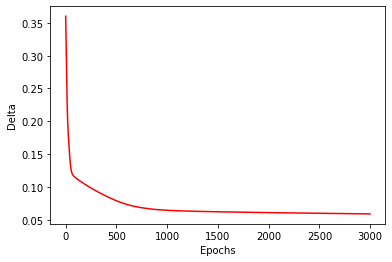

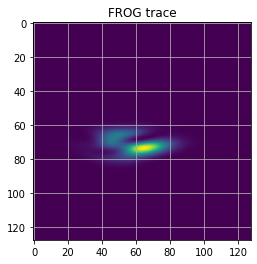

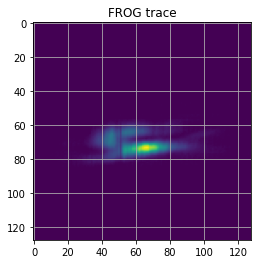

In [14]:
T1 = 500
T2 = 500
gradient_d(T1, T2, i0, A, f0, a, a2, a3, f1, tau1, math.pi)
FROG_trace_plot(original_trace)

In [ ]:
min = 0.1879766965862657

In [ ]:
delta =  0.058856174803190456 
T1 = 410.646076434209 
T2 = 1032.7593921577948 
A = 0.6642422917436082 
a = 1 
f0 = 0.0007413895863495356 
a2 = -3.6654937645816873e-06 
a3 = -1.3977803408472281e-09 
f1 = 0.00043176484687512304 
tau = 3026.546006539186 
phi =  3.544329975346816
(FROG, delta) = FROGs(T1,T2,i0,A,f0,a,a2,a3,f1, tau, tau, phi - 2*math.pi) 
FROG_trace_plot(FROG)
print(delta)